In [2]:
import numpy as np
import torch
import gpytorch
import botorch
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.max_value_entropy_search import qMultiFidelityMaxValueEntropy
from botorch.acquisition import PosteriorMean
from botorch.optim.optimize import optimize_acqf_mixed, optimize_acqf
from torch.quasirandom import SobolEngine
import matplotlib.pyplot as plt

In [3]:
# reproducibility
torch.manual_seed(0)
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

/var/folders/mg/l5f3xml94wjb2ks03kfgl9840000gn/T/ipykernel_32640/697909300.py:72: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(cnt, ax=ax)


Next query (x1, x2, fidelity): [[-4.607285  2.498696  0.5     ]] acq_val: 0.003762881038710475
Final recommendation (high fidelity): [[-4.616901   2.5055902]]


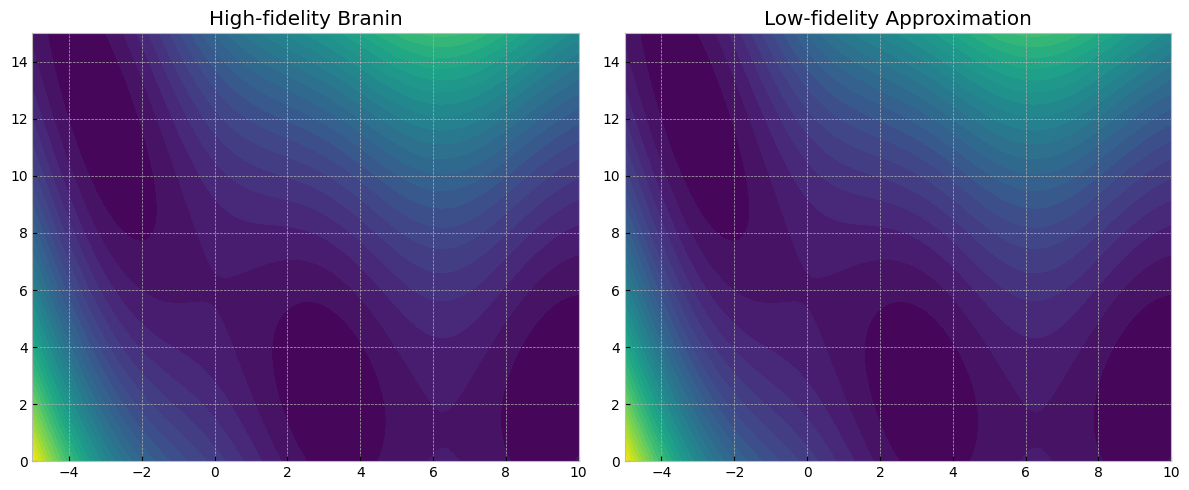

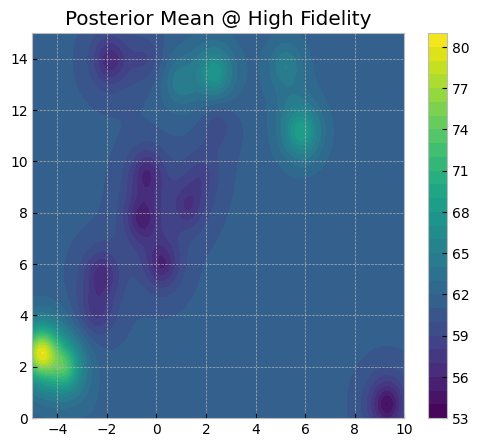

In [4]:
# High-fidelity Branin–Hoo (PyTorch)
def branin(x):
    # x: tensor of shape (..., 2)
    a = 1.0
    b = 5.1 / (4.0 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8.0 * np.pi)
    x1 = x[..., 0]
    x2 = x[..., 1]
    term1 = a * (x2 - b * x1**2 + c * x1 - r)**2
    term2 = s * (1 - t) * torch.cos(x1)
    return term1 + term2 + s

# Low-fidelity approximation (e.g., scaled + bias)
def approx_branin(x):
    return 0.5 * branin(x) + 5.0  # simple shift

# 3) Domain and fidelity setup
bounds = torch.tensor([[-5.0,  0.0],
                       [10.0, 15.0]], dtype=torch.float)   # [2 x 2]
fidelities = torch.tensor([0.5, 1.0])  # low (=0.5) and high (=1.0)

# Generate a grid for plotting
n_grid = 101
x1 = torch.linspace(bounds[0,0], bounds[1,0], n_grid)
x2 = torch.linspace(bounds[0,1], bounds[1,1], n_grid)
X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
grid = torch.stack([X1.flatten(), X2.flatten()], dim=-1)

# Plot the two fidelities
with torch.no_grad():
    Z_h = branin(grid).reshape(n_grid, n_grid)
    Z_l = approx_branin(grid).reshape(n_grid, n_grid)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
cs0 = ax[0].contourf(X1, X2, Z_h, levels=30)
ax[0].set_title("High-fidelity Branin")
cs1 = ax[1].contourf(X1, X2, Z_l, levels=30, cmap="viridis")
ax[1].set_title("Low-fidelity Approximation")
plt.tight_layout()

# Initial mixed-fidelity observations
n_init = 20
train_x = torch.rand(n_init, 2)
train_x = bounds[0] + (bounds[1] - bounds[0]) * train_x
train_f = fidelities[torch.randint(2, (n_init, 1))]        # random fidelity
train_x_full = torch.cat([train_x, train_f], dim=-1)       # [n x 3]
train_y = torch.stack([
    branin(x) if f.item()==1.0 else approx_branin(x)
    for x,f in zip(train_x, train_f)
]).unsqueeze(-1)

# Fit multi-fidelity GP
model = SingleTaskMultiFidelityGP(train_x_full, train_y, data_fidelity=2)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

# 8) Predict on high fidelity grid
with torch.no_grad():
    # append fidelity=1 to grid
    grid_h = torch.cat([grid, torch.ones(grid.shape[0],1)], dim=-1)
    post = model(grid_h)
    mean_h = post.mean
    lower, upper = post.confidence_region()

# Visualize posterior mean + CI
fig, ax = plt.subplots(1,1, figsize=(6,5))
cnt = ax.tricontourf(grid[:,0], grid[:,1], mean_h.numpy(), levels=30)
ax.set_title("Posterior Mean @ High Fidelity")
plt.colorbar(cnt, ax=ax)

# Cost‐aware acquisition (knowledge‐entropy)
cost_model = AffineFidelityCostModel(fixed_cost=10.0, fidelity_weights={2:1.0})
utility  = InverseCostWeightedUtility(cost_model=cost_model)
sobol    = SobolEngine(2, scramble=True).draw(500)
cand     = bounds[0] + (bounds[1]-bounds[0])*sobol
# always evaluate candidates at high fid for entropy
cand_full = torch.cat([cand, torch.ones(500,1)], dim=-1)

policy = qMultiFidelityMaxValueEntropy(
    model, cand_full, num_fantasies=64,
    cost_aware_utility=utility,
    project=lambda x: x  # identity, since we already include fidelity
)

with torch.no_grad():
    # compute acquisition on a line slice y=7.5 as example
    slice_pts = torch.stack([x1, torch.full_like(x1,7.5)], dim=-1)
    slice_h = torch.cat([slice_pts, torch.ones(n_grid,1)], dim=-1)
    acq_vals = policy(slice_h.unsqueeze(1)).squeeze(-1)

# Optimize acquisition to get next query (mixed fidelities allowed)
next_x_full, acq_val = optimize_acqf_mixed(
    policy,
    bounds = torch.cat([bounds, torch.tensor([[0.5],[1.0]])], dim=1),
    fixed_features_list = [{2: f.item()} for f in fidelities],
    q=1, num_restarts=10, raw_samples=100,
)

print("Next query (x1, x2, fidelity):", next_x_full.numpy(), "acq_val:", acq_val.item())

# Final recommendation at high fidelity
post_mean_acq = FixedFeatureAcquisitionFunction(
    PosteriorMean(model), d=3, columns=[2], values=[1.0]
)
final_x, _ = optimize_acqf(post_mean_acq, bounds=bounds, q=1,
                           num_restarts=10, raw_samples=100)
print("Final recommendation (high fidelity):", final_x.numpy())
